In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.stats import ks_2samp
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import trange
from umap.parametric_umap import ParametricUMAP

In [ ]:
data = np.load("data/ihb.npy")

In [ ]:
# Check the shape of the data
print("Original shape:", data.shape)  # Should be (320, 10, 246)

# Create a mask to identify samples with NaNs in the last dimension
mask_nan = np.isnan(data).any(axis=(1, 2))

# Split the data into two arrays
data_no_nans = data[~mask_nan]  # Samples without NaNs
data_with_nans = data[mask_nan][:, :, :200]  # Samples with NaNs

Original shape: (320, 10, 246)


In [ ]:
mask_nan

array([False,  True, False, False,  True,  True, False, False,  True,
        True,  True, False, False,  True, False,  True,  True,  True,
        True, False, False, False,  True, False, False,  True,  True,
       False,  True, False,  True, False, False,  True, False, False,
        True, False,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True, False,
       False,  True, False,  True,  True, False,  True,  True, False,
       False,  True,  True,  True, False,  True, False,  True, False,
        True, False, False,  True, False,  True, False,  True, False,
        True, False,  True,  True,  True, False, False,  True,  True,
        True, False, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True,  True, False, False,  True,  True,
       False, False,  True, False, False, False,  True,  True, False,
       False, False,

In [ ]:
# Output shapes of the split arrays
print("Shape of data without NaNs:", data_no_nans.shape)
print("Shape of data with NaNs:", data_with_nans.shape)

Shape of data without NaNs: (160, 10, 246)
Shape of data with NaNs: (160, 10, 200)


In [ ]:
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)

    # Z-normalize the data
    normalized_data = (data - mean) / std

    # The shape of normalized_data will be (160, 10, 246)
    return normalized_data


data_no_nans = normalize(data_no_nans)
data_with_nans = normalize(data_with_nans)

In [ ]:
def get_corr_matrics(some_data):

    correlation_matrices = []

    # Loop over each scan
    for i in range(some_data.shape[0]):
        # Get the time series for all brain regions in this scan (shape: 10, 246)
        time_series = some_data[i, :, :]

        # Compute the Pearson correlation matrix (shape: 246, 246)
        corr_matrix = np.corrcoef(time_series, rowvar=False)

        # Append the correlation matrix to the list
        correlation_matrices.append(corr_matrix)

    # Convert the list to a numpy array (shape: 320, 246, 246)
    correlation_matrices = np.array(correlation_matrices)

    # Output the shape to confirm the result
    print("Shape of correlation matrices:", correlation_matrices.shape)

    return correlation_matrices

In [ ]:
def fisher_transform(corr):
    # Clip values to avoid issues with arccosh for values very close to -1 or 1
    corr = np.clip(corr, -0.999999, 0.999999)
    return 0.5 * np.log((1 + corr) / (1 - corr))


# Assuming your correlation matrix is named `correlation_matrices`
# with shape (320, 246, 246)
# def apply_transforms(correlation_matrices):
#     # Step 1: Fisher's r-to-z transformation
#     def fisher_transform(corr):
#         # Clip values to avoid issues with arccosh for values very close to -1 or 1
#         corr = np.clip(corr, -0.999999, 0.999999)
#         return 0.5 * np.log((1 + corr) / (1 - corr))

#     # Apply Fisher transformation to each correlation matrix
#     z_matrices = fisher_transform(correlation_matrices)

#     # Step 2: Pseudo z-scoring
#     # Here we will standardize each matrix (mean = 0, std = 1)
#     def pseudo_z_score(z_matrices):
#         # Calculate mean and std along the last two dimensions (246, 246)
#         mean = np.mean(z_matrices, axis=(1, 2), keepdims=True)
#         std = np.std(z_matrices, axis=(1, 2), keepdims=True)

#         # Standardize
#         return (z_matrices - mean) / std

#     # Apply pseudo z-scoring
#     return pseudo_z_score(z_matrices)

In [ ]:
no_nans_corr = get_corr_matrics(data_no_nans)
with_nans_corr = get_corr_matrics(data_with_nans)

Shape of correlation matrices: (160, 246, 246)
Shape of correlation matrices: (160, 200, 200)


In [ ]:
# Assuming `correlation_matrices` is of shape (320, 246, 246)


# Function to extract the upper triangle of the correlation matrix, excluding the diagonal
def flatten_upper_triangle(matrix):
    return matrix[np.triu_indices_from(matrix, k=1)]  # k=1 excludes the diagonal


# Flatten each 246x246 correlation matrix into a 1D vector (upper triangle only)
flattened_matrices_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in with_nans_corr]
)

flattened_matrices_no_nans = np.array(
    [flatten_upper_triangle(matrix) for matrix in no_nans_corr]
)

In [ ]:
print("Shape of flattened matrices with NaNs:", flattened_matrices_nans.shape)
print("Shape of flattened matrices without NaNs:", flattened_matrices_no_nans.shape)

Shape of flattened matrices with NaNs: (160, 19900)
Shape of flattened matrices without NaNs: (160, 30135)


  0%|          | 0/160 [00:00<?, ?it/s]

[ 7  6  9 17  6  5  4  9  4 12  4  5 18  7  6  9  2  4  5  3  4 14  3  4
  6  7 15 12  5  6  7  9 20  4 14  4  4  7  1  7 14  5 14  4 17  7  3  9
  7  2  9  4  4  4  4  9  3  9  5  4 13  5  5  4  6  4 13  7  4  4  4  4
 13  9 10  4  4  6  9 18  7  6  4  7  4  4 11 11  4  7  4  7  7  4  7  7
  4 10  6  4  1  4  7 19 14  8 15  9  6  4  7  5  4  3  9  9  4  8  4  7
  2  3  4  6  7  7  9 16 16  9  4  2  4  5  4  4  4  5  4  4 14 17  9  4
  7  4  2  9  2  9  4  6 16  5  9  3  4  9  4  7]


/tmp/ipykernel_45413/3553391773.py:22: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(ks_stats, method='average')


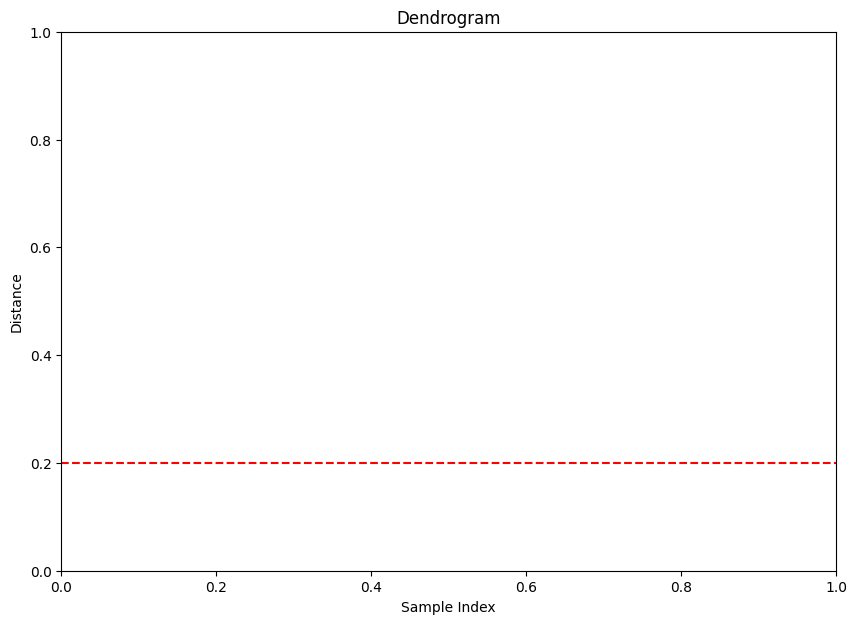

In [ ]:
# Assume `data` is your numpy array of shape (160, 19900)
data = flattened_matrices_nans  # Replace this with your actual data

# Step 1: Calculate the pairwise KS statistics
n_samples = data.shape[0]
ks_stats = np.zeros((n_samples, n_samples))

for i in trange(n_samples):
    for j in range(i + 1, n_samples):
        stat, _ = ks_2samp(data[i], data[j])
        ks_stats[i, j] = stat
        ks_stats[j, i] = stat  # Symmetric

# Step 2: Perform hierarchical clustering
# We can use the average linkage method for hierarchical clustering
linkage_matrix = linkage(ks_stats, method="average")

# Step 3: Form flat clusters
# We want 20 clusters of 8 samples each
clusters = fcluster(linkage_matrix, t=20, criterion="maxclust")

# Output the cluster labels
print(clusters)

# Optional: Plot the dendrogram
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
plt.xlabel("Sample Index")
plt.ylabel("Distance")
plt.axhline(
    y=0.2, color="r", linestyle="--"
)  # You can adjust this threshold for better visualization
plt.show()

In [ ]:
data_no_nans[0].shape

(10, 246)

In [ ]:
no_nans_corr.shape

(160, 246, 246)

<Axes: >

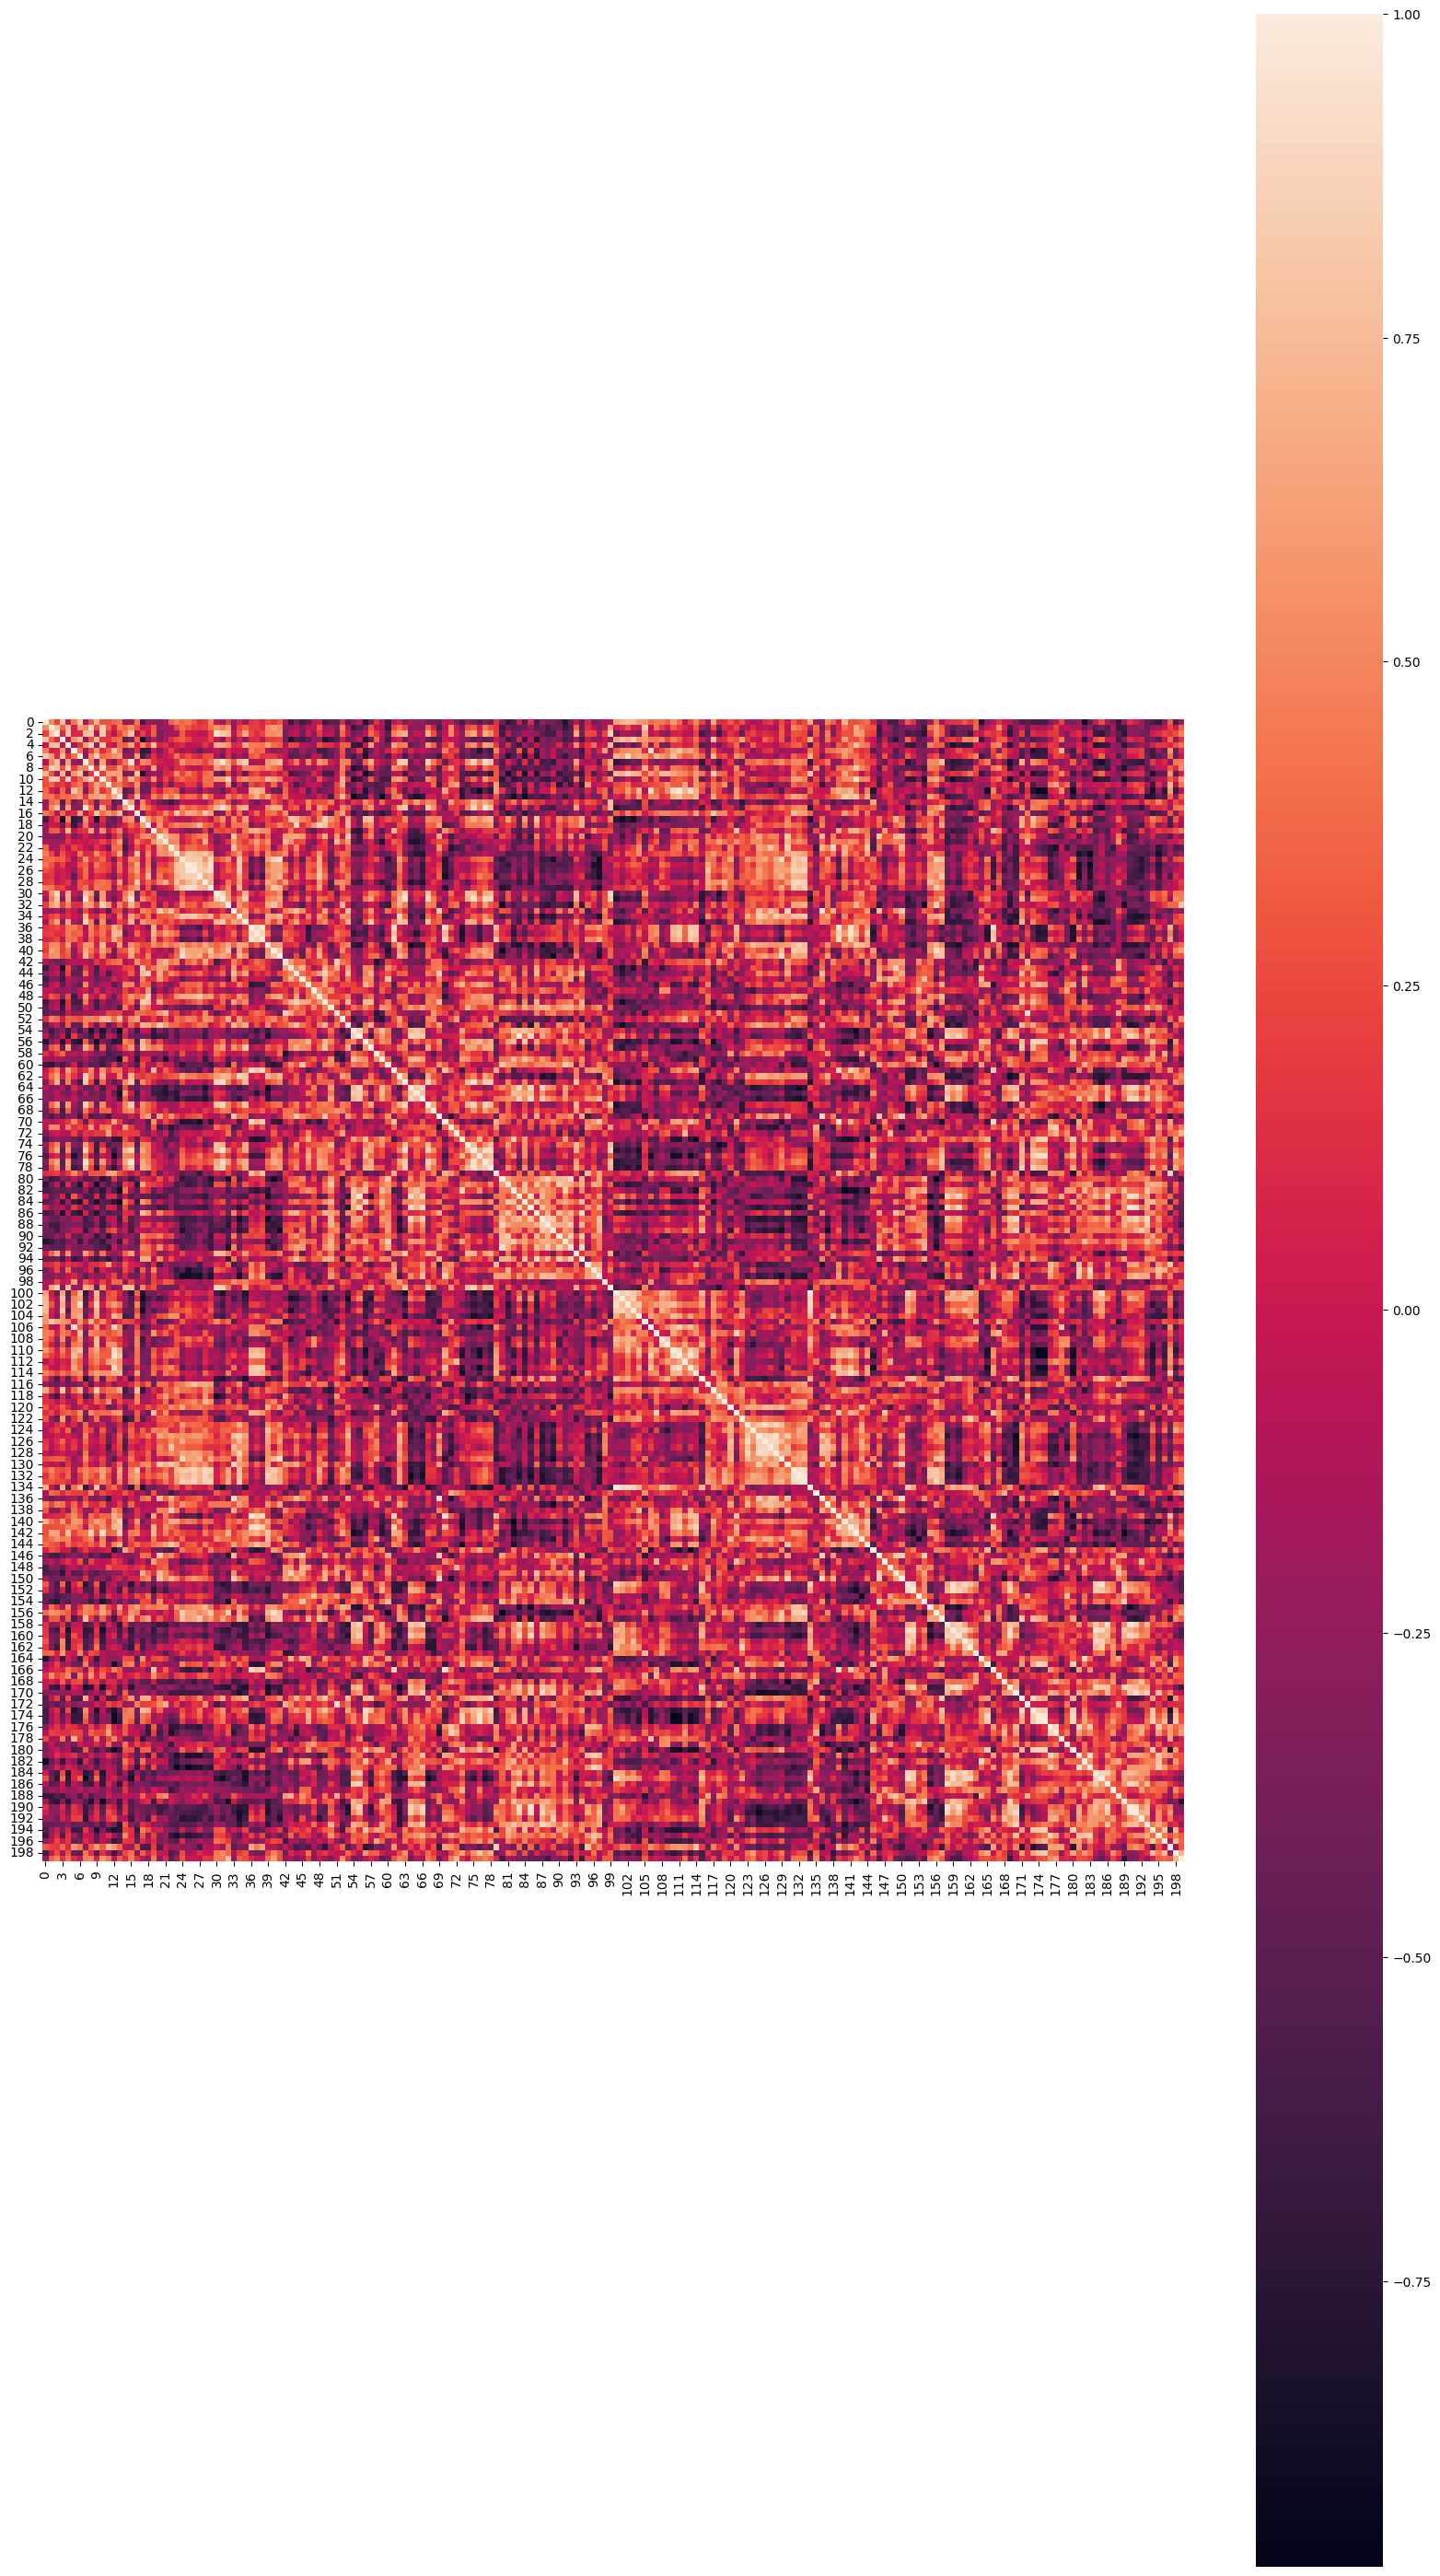

In [ ]:
plt.figure(figsize=(20, 36))
sns.heatmap(with_nans_corr[2], square=True)

<Axes: >

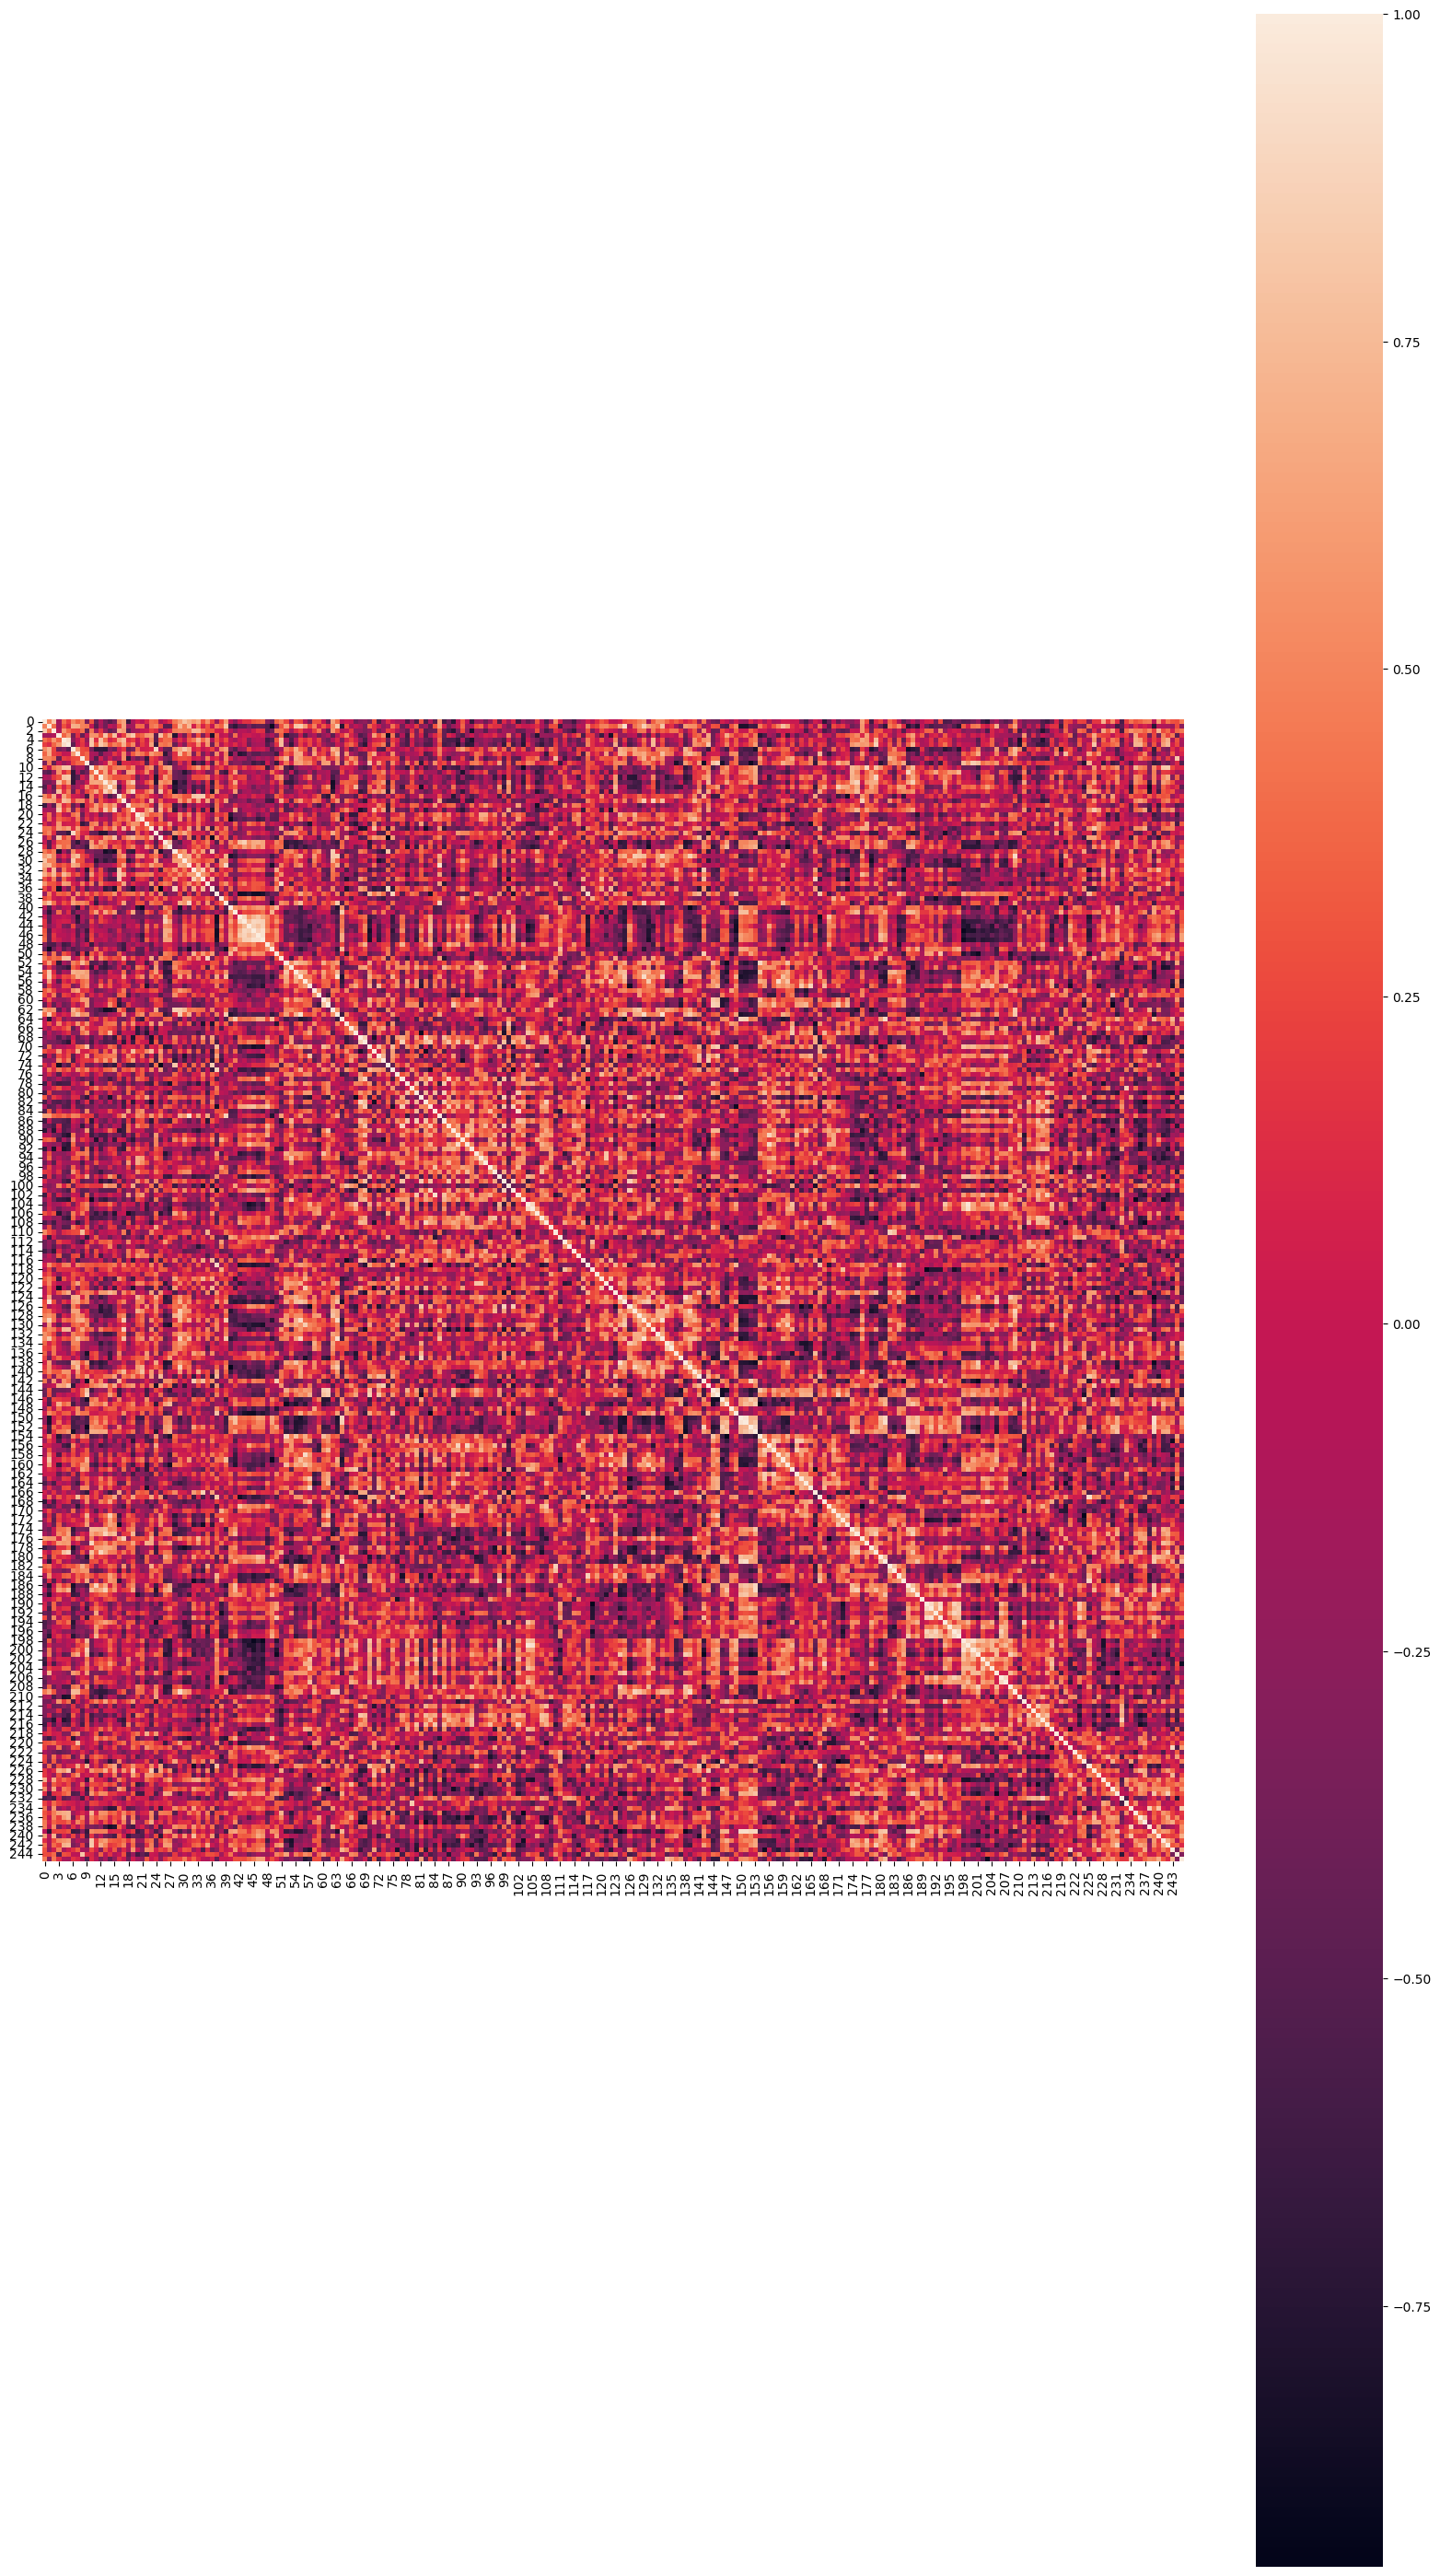

In [ ]:
plt.figure(figsize=(20, 36))
sns.heatmap(no_nans_corr[2], square=True)
# cbar_kws={"fraction": 0.01},  )

<Axes: >

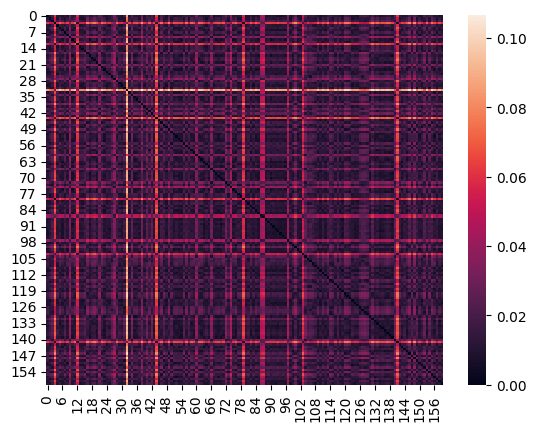

In [ ]:
sns.heatmap(ks_stats)

In [ ]:
pd.DataFrame({"test": clusters})["test"].value_counts()

test
4     49
7     23
9     20
6     12
5     12
3      7
2      6
14     6
17     3
13     3
16     3
18     2
12     2
15     2
1      2
10     2
11     2
8      2
20     1
19     1
Name: count, dtype: int64

In [ ]:
# Assuming your arrays are named 'flattened_with_nans' and 'flattened_without_nans'
flattened_with_nans = flattened_matrices_nans  # Replace this with your actual data
flattened_without_nans = flattened_matrices_no_nans  # Replace this with your actual data

# Initialize lists to store KS statistics and p-values
ks_statistics = []
p_values = []

# Ensure the two arrays have compatible dimensions for pairwise comparison
num_rows = min(flattened_with_nans.shape[0], flattened_without_nans.shape[0])
num_columns_with_nans = flattened_with_nans.shape[1]
num_columns_without_nans = flattened_without_nans.shape[1]

# Iterate through each row and perform the KS test
for i in range(num_rows):
    # Flatten the current row (assuming you want to compare entire rows)
    sample1 = flattened_with_nans[i]
    sample2 = flattened_without_nans[
        i % num_columns_without_nans
    ]  # or select a relevant row based on your needs

    # Remove NaNs from the first sample
    sample1 = sample1[~np.isnan(sample1)]

    # Perform the KS test
    ks_statistic, p_value = ks_2samp(sample1, sample2)

    # Append results
    ks_statistics.append(ks_statistic)
    p_values.append(p_value)

# Convert results to arrays for better handling
ks_statistics = np.array(ks_statistics)
p_values = np.array(p_values)

# Output the results
for i in range(num_rows):
    print(f"Row {i}: KS Statistic = {ks_statistics[i]:.4f}, p-value = {p_values[i]:.4f}")

Row 0: KS Statistic = 0.0192, p-value = 0.0003
Row 1: KS Statistic = 0.0274, p-value = 0.0000
Row 2: KS Statistic = 0.0238, p-value = 0.0000
Row 3: KS Statistic = 0.0742, p-value = 0.0000
Row 4: KS Statistic = 0.0213, p-value = 0.0000
Row 5: KS Statistic = 0.0104, p-value = 0.1468
Row 6: KS Statistic = 0.0175, p-value = 0.0012
Row 7: KS Statistic = 0.0100, p-value = 0.1799
Row 8: KS Statistic = 0.0146, p-value = 0.0117
Row 9: KS Statistic = 0.0372, p-value = 0.0000
Row 10: KS Statistic = 0.0081, p-value = 0.4133
Row 11: KS Statistic = 0.0103, p-value = 0.1523
Row 12: KS Statistic = 0.0143, p-value = 0.0150
Row 13: KS Statistic = 0.0148, p-value = 0.0107
Row 14: KS Statistic = 0.0157, p-value = 0.0055
Row 15: KS Statistic = 0.0137, p-value = 0.0217
Row 16: KS Statistic = 0.0104, p-value = 0.1490
Row 17: KS Statistic = 0.0056, p-value = 0.8487
Row 18: KS Statistic = 0.0150, p-value = 0.0092
Row 19: KS Statistic = 0.0224, p-value = 0.0000
Row 20: KS Statistic = 0.0113, p-value = 0.0947
Ro

In [ ]:
flattened_matrices_nans.var()

0.1429961070620696

In [ ]:
flattened_matrices_no_nans.var()

0.1367677768715662

In [ ]:
ks_statistic, p_value = ks_2samp(
    flattened_matrices_no_nans[20], flattened_matrices_nans[70]
)
print(f"KS Statistic: {ks_statistic}, p-value: {p_value}")

KS Statistic: 0.007706835154701719, p-value: 0.4725917708840828


In [ ]:
ks_statistic, p_value = ks_2samp(
    flattened_matrices_no_nans[40], flattened_matrices_nans[70]
)
print(f"KS Statistic: {ks_statistic}, p-value: {p_value}")

KS Statistic: 0.02595191821059839, p-value: 1.9116676909448786e-07


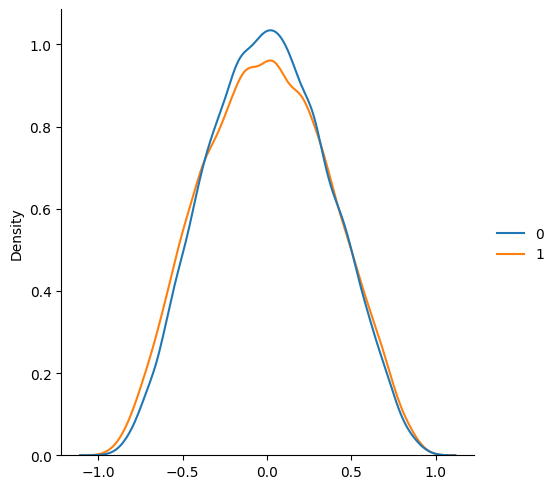

In [ ]:
sns.displot(
    [flattened_matrices_no_nans[40], flattened_matrices_nans[70]],
    kind="kde",
    common_norm=False,
)

In [ ]:
flattened_matrices_no_nans[70].max()

0.9758225813981845

In [ ]:
flattened_matrices_nans[40].max()

0.971053069987015

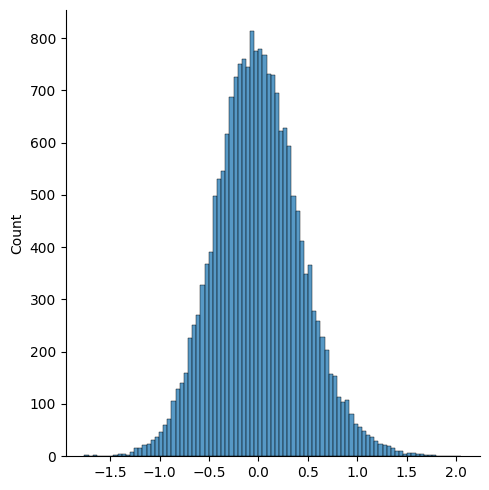

In [ ]:
sns.displot()

In [ ]:
test = np.concatenate(
    (flattened_matrices_nans, flattened_matrices_no_nans[:, :19900]), axis=0
)

In [ ]:
test.shape

(320, 19900)

I0000 00:00:1728399259.967592   45413 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-08 17:54:19.969026: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.3081
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2760
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.2755
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2742
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2738
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2734
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2732
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - loss: 0.2724
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2722
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 0.2723


/tmp/ipykernel_45413/1722282290.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(


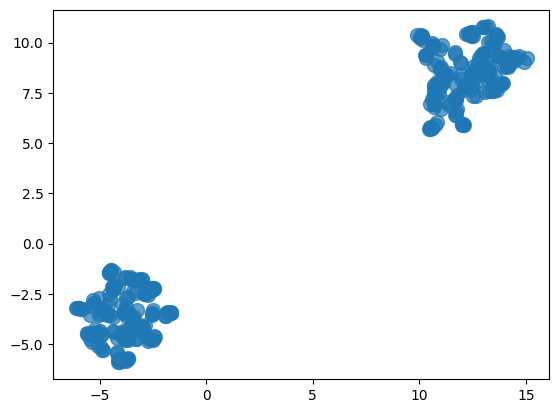

In [ ]:
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 2  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_nans = umap_model_nans.fit_transform(test)
scatter = plt.scatter(
    umap_result_nans[:, 0],
    umap_result_nans[:, 1],
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

In [ ]:
# Set UMAP parameters
n_neighbors = 8  # You can adjust this value
min_dist = 0.1  # You can adjust this value
n_components = 50  # You can adjust the number of components

# Apply UMAP to the data with NaN values
umap_model_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_nans = umap_model_nans.fit_transform(flattened_matrices_nans)

# Apply UMAP to the data without NaN values
umap_model_no_nans = umap.ParametricUMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    random_state=42,
)
umap_result_no_nans = umap_model_no_nans.fit_transform(flattened_matrices_no_nans)

# Concatenate the UMAP results
flattened_matrices = np.concatenate((umap_result_nans, umap_result_no_nans), axis=0)

print("Shape of flattened matrices:", flattened_matrices.shape)

2024-10-06 20:28:08.428955: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 20:28:08.453671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-06 20:28:08.468881: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-06 20:28:08.487630: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-06 20:28:08.492673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-06 20:28:08.509528: I tensorflow/core/platform/cpu_feature_gu

Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.3635
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3233
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3225
Epoch 4/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3221
Epoch 5/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3228
Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.3196
Epoch 7/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3232
Epoch 8/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 0.3201
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3205
Epoch 10/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.3204


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Epoch 1/10


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'umap_model', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 0.3784
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3305
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3271
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3303
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3281
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.3269
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3261
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3287
Epoch 9/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3270
Epoch 10/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.3264
Shape of flattened matrices: (320, 50)


/home/seara/Desktop/Github/AIDAO/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


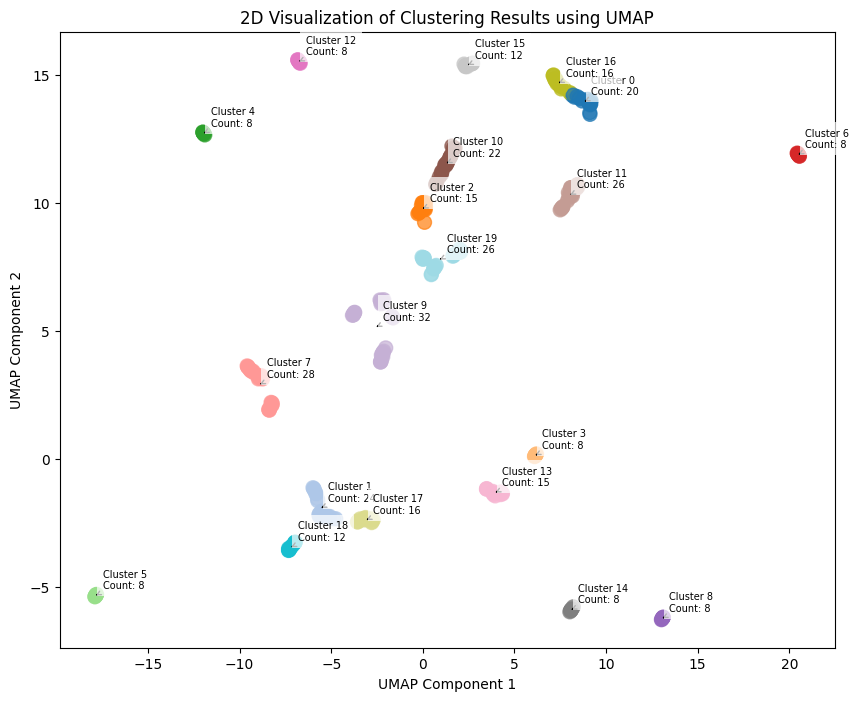

In [ ]:
# Assuming `flattened_matrices` contains the 1D vectors of upper triangles of the correlation matrices

# Step 1: Dimensionality reduction using UMAP to 2 dimensions
umap_reducer = umap.UMAP(
    n_components=2,
    n_neighbors=16,
    min_dist=0.1,
    random_state=42,
    spread=1,  # metric="correlation"
)
reduced_data = umap_reducer.fit_transform(flattened_matrices)

# Step 2: Perform K-Means clustering on the UMAP reduced data
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=42, max_iter=1000)
kmeans.fit(reduced_data)

# Step 3: Get the cluster labels for each scan
cluster_labels = kmeans.labels_

unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts, strict=False))

# Calculate the centroids of each cluster
centroids = np.array(
    [reduced_data[cluster_labels == i].mean(axis=0) for i in range(num_clusters)]
)

# Step 4: Plotting the clusters in 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_data[:, 0],
    reduced_data[:, 1],
    c=cluster_labels,
    cmap="tab20",  # Change to a more distinct colormap
    s=100,  # Increased size for better visibility
    alpha=0.7,
)

# Adding labels and title
plt.title("2D Visualization of Clustering Results using UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")

# Annotate the centroids with the number of objects in each cluster
for i in range(num_clusters):
    plt.annotate(
        f"Cluster {i}\nCount: {cluster_counts[i]}",  # Text to display
        xy=centroids[i],  # Coordinates of the centroid
        xytext=(5, 5),  # Offset for the text
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox={"facecolor": "white", "alpha": 0.7, "edgecolor": "none"},
        arrowprops={"arrowstyle": "->", "lw": 1, "color": "black"},
    )

# Show color bar
# Not applicable here since we are using custom colors for clusters
plt.show()

In [ ]:
# Assume 'data' is your original data array
# cluster_labels is the prediction for the concatenated data

# Step 1: Initialize an array for the original shape of data with NaN
original_labels = np.full(data.shape[0], np.nan)

# Assuming data is 3D, adjust accordingly

# Step 2: Assign the cluster labels back
# For samples without NaNs
original_labels[~mask_nan] = cluster_labels[data_no_nans.shape[0] :]

# For samples with NaNs
original_labels[mask_nan] = cluster_labels[: data_with_nans.shape[0]]

submission_df = pd.DataFrame({"prediction": original_labels})
submission_df["prediction"] = submission_df["prediction"].astype(int)
# Save the submission to a CSV file
submission_df.to_csv("submissions/" + "bullshit4.csv", index=False)